[View in Colaboratory](https://colab.research.google.com/github/x110/DLToolboxImg/blob/master/FindLR.ipynb)

## Below I show an implementation of how to find the learning rate to use when training deep neural networks. 

## Install dependencies on Google colab


In [1]:
# Prepare Machine
## install dependencies
!apt install libnvrtc8.0
!pip install mxnet-cu80
!apt-get install ffmpeg
!apt-get install imagemagick
!pip install pylidc
!pip install dicom

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libnvrtc8.0
0 upgraded, 1 newly installed, 0 to remove and 0 not upgraded.
Need to get 6,225 kB of archives.
After this operation, 28.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvrtc8.0 amd64 8.0.61-1 [6,225 kB]
Fetched 6,225 kB in 1s (6,096 kB/s)

78Selecting previously unselected package libnvrtc8.0:amd64.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../libnvrtc8.0_8.0.61-1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [ 16%] [#########.................................................] 8Unpacking libnvrtc8.0:amd64 (8.0.61-1) ...
7Progress: [ 33%] [###################.......................................] 87Progress: [ 50%] [#############################........

    100% |████████████████████████████████| 270.0MB 59kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  dbus i965-va-driver libaacs0 libapparmor1 libasound2 libasound2-data libass9
  libasyncns0 libavc1394-0 libavcodec57 libavdevice57 libavfilter6
  libavformat57 libavresample3 libavutil55 libbdplus0 libbluray2
  libboost-filesystem1.62.0 libboost-system1.62.0 libbs2b0 libcaca0 libcairo2
  libcapnp-0.5.3 libcdio-cdda1 libcdio-paranoia1 libcdio13 libchromaprint1
  libcrystalhd3 libdbus-1-3 libdc1394-22 libdrm-amdgpu1 libdrm-common
  libdrm-intel1 libdrm-nouveau2 libdrm-radeon1 libdrm2 libegl1-mesa libelf1
  libfftw3-double3 libflac8 libflite1 libfribidi0 libgbm1 libgl1-mesa-dri
  libgl1-mesa-glx libglapi-mesa libgme0 libgraphite2-3 libgsm1 libharfbuzz0b
  libiec61883-0 libjack-jackd2-0 libllvm5.0 libmirclient9 libmircommon7
  libmircore1 libmirprotobuf3 libmp3lame0 libmpg123-0 libn

Get:12 http://archive.ubuntu.com/ubuntu artful/main amd64 xkb-data all 2.19-1.1ubuntu1 [312 kB]
Get:13 http://archive.ubuntu.com/ubuntu artful/main amd64 libdrm-common all 2.4.83-1 [4,938 B]
Get:14 http://archive.ubuntu.com/ubuntu artful/main amd64 libdrm2 amd64 2.4.83-1 [30.6 kB]
Get:15 http://archive.ubuntu.com/ubuntu artful/main amd64 libnuma1 amd64 2.0.11-2.1 [21.6 kB]
Get:16 http://archive.ubuntu.com/ubuntu artful/main amd64 libusb-1.0-0 amd64 2:1.0.21-2 [43.3 kB]
Get:17 http://archive.ubuntu.com/ubuntu artful/universe amd64 libva-drm1 amd64 1.8.3-2 [7,858 B]
Get:18 http://archive.ubuntu.com/ubuntu artful/universe amd64 libva1 amd64 1.8.3-2 [44.9 kB]
Get:19 http://archive.ubuntu.com/ubuntu artful/main amd64 libxfixes3 amd64 1:5.0.3-1 [10.8 kB]
Get:20 http://archive.ubuntu.com/ubuntu artful/universe amd64 libva-x11-1 amd64 1.8.3-2 [11.4 kB]
Get:21 http://archive.ubuntu.com/ubuntu artful/main amd64 libvdpau1 amd64 1.1.1-3ubuntu1 [25.5 kB]
Get:22 http://archive.ubuntu.com/ubuntu artf

Get:93 http://archive.ubuntu.com/ubuntu artful/main amd64 libdrm-nouveau2 amd64 2.4.83-1 [16.4 kB]
Get:94 http://archive.ubuntu.com/ubuntu artful/main amd64 libdrm-radeon1 amd64 2.4.83-1 [21.6 kB]
Get:95 http://archive.ubuntu.com/ubuntu artful/main amd64 libllvm5.0 amd64 1:5.0-3 [13.7 MB]
Get:96 http://archive.ubuntu.com/ubuntu artful/main amd64 libsensors4 amd64 1:3.4.0-4 [28.8 kB]
Get:97 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libgl1-mesa-dri amd64 17.2.8-0ubuntu0~17.10.1 [5,707 kB]
Get:98 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libgl1-mesa-glx amd64 17.2.8-0ubuntu0~17.10.1 [130 kB]
Get:99 http://archive.ubuntu.com/ubuntu artful/main amd64 libiec61883-0 amd64 1.2.0-2 [23.5 kB]
Get:100 http://archive.ubuntu.com/ubuntu artful/main amd64 libjack-jackd2-0 amd64 1.9.10+20150825git1ed50c92~dfsg-5ubuntu1 [256 kB]
Get:101 http://archive.ubuntu.com/ubuntu artful/universe amd64 libopenal-data all 1:1.17.2-4 [101 kB]
Get:102 http://archive.ubuntu.com/ubuntu

Get:130 http://archive.ubuntu.com/ubuntu artful/main amd64 libxv1 amd64 2:1.0.11-1 [10.7 kB]
Get:131 http://archive.ubuntu.com/ubuntu artful/universe amd64 libavdevice57 amd64 7:3.3.4-2 [73.7 kB]
Get:132 http://archive.ubuntu.com/ubuntu artful/universe amd64 ffmpeg amd64 7:3.3.4-2 [1,524 kB]
Get:133 http://archive.ubuntu.com/ubuntu artful/universe amd64 libaacs0 amd64 0.9.0-1 [51.4 kB]
Get:134 http://archive.ubuntu.com/ubuntu artful/universe amd64 libbdplus0 amd64 0.1.2-2 [46.6 kB]
Get:135 http://archive.ubuntu.com/ubuntu artful-updates/universe amd64 mesa-va-drivers amd64 17.2.8-0ubuntu0~17.10.1 [1,532 kB]
Get:136 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 mesa-vdpau-drivers amd64 17.2.8-0ubuntu0~17.10.1 [1,658 kB]
Get:137 http://archive.ubuntu.com/ubuntu artful/main amd64 tcpd amd64 7.6.q-26 [23.5 kB]
Get:138 http://archive.ubuntu.com/ubuntu artful/universe amd64 i965-va-driver amd64 1.8.3-1ubuntu1 [633 kB]
Get:139 http://archive.ubuntu.com/ubuntu artful/universe amd6

Unpacking libva-x11-1:amd64 (1.8.3-2) ...
Selecting previously unselected package libvdpau1:amd64.
Preparing to unpack .../020-libvdpau1_1.1.1-3ubuntu1_amd64.deb ...
Unpacking libvdpau1:amd64 (1.1.1-3ubuntu1) ...
Selecting previously unselected package libavutil55:amd64.
Preparing to unpack .../021-libavutil55_7%3a3.3.4-2_amd64.deb ...
Unpacking libavutil55:amd64 (7:3.3.4-2) ...
Selecting previously unselected package libcrystalhd3:amd64.
Preparing to unpack .../022-libcrystalhd3_1%3a0.0~git20110715.fdd2f19-12_amd64.deb ...
Unpacking libcrystalhd3:amd64 (1:0.0~git20110715.fdd2f19-12) ...
Selecting previously unselected package libmp3lame0:amd64.
Preparing to unpack .../023-libmp3lame0_3.99.5+repack1-9build1_amd64.deb ...
Unpacking libmp3lame0:amd64 (3.99.5+repack1-9build1) ...
Selecting previously unselected package libopenjp2-7:amd64.
Preparing to unpack .../024-libopenjp2-7_2.2.0-1_amd64.deb ...
Unpacking libopenjp2-7:amd64 (2.2.0-1) ...
Selecting previously unselected package libopu

Selecting previously unselected package libavc1394-0:amd64.
Preparing to unpack .../052-libavc1394-0_0.5.4-4_amd64.deb ...
Unpacking libavc1394-0:amd64 (0.5.4-4) ...
Selecting previously unselected package libgraphite2-3:amd64.
Preparing to unpack .../053-libgraphite2-3_1.3.10-2_amd64.deb ...
Unpacking libgraphite2-3:amd64 (1.3.10-2) ...
Selecting previously unselected package libharfbuzz0b:amd64.
Preparing to unpack .../054-libharfbuzz0b_1.4.2-1_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (1.4.2-1) ...
Selecting previously unselected package libass9:amd64.
Preparing to unpack .../055-libass9_1%3a0.13.7-2_amd64.deb ...
Unpacking libass9:amd64 (1:0.13.7-2) ...
Selecting previously unselected package libbluray2:amd64.
Preparing to unpack .../056-libbluray2_1%3a1.0.1.deb1-2_amd64.deb ...
Unpacking libbluray2:amd64 (1:1.0.1.deb1-2) ...
Selecting previously unselected package libchromaprint1:amd64.
Preparing to unpack .../057-libchromaprint1_1.4.2-1_amd64.deb ...
Unpacking libchromaprint1:a

Selecting previously unselected package libglapi-mesa:amd64.
Preparing to unpack .../081-libglapi-mesa_17.2.8-0ubuntu0~17.10.1_amd64.deb ...
Unpacking libglapi-mesa:amd64 (17.2.8-0ubuntu0~17.10.1) ...
Selecting previously unselected package libx11-xcb1:amd64.
Preparing to unpack .../082-libx11-xcb1_2%3a1.6.4-3_amd64.deb ...
Unpacking libx11-xcb1:amd64 (2:1.6.4-3) ...
Selecting previously unselected package libxcb-dri2-0:amd64.
Preparing to unpack .../083-libxcb-dri2-0_1.12-1ubuntu1_amd64.deb ...
Unpacking libxcb-dri2-0:amd64 (1.12-1ubuntu1) ...
Selecting previously unselected package libxcb-dri3-0:amd64.
Preparing to unpack .../084-libxcb-dri3-0_1.12-1ubuntu1_amd64.deb ...
Unpacking libxcb-dri3-0:amd64 (1.12-1ubuntu1) ...
Selecting previously unselected package libxcb-glx0:amd64.
Preparing to unpack .../085-libxcb-glx0_1.12-1ubuntu1_amd64.deb ...
Unpacking libxcb-glx0:amd64 (1.12-1ubuntu1) ...
Selecting previously unselected package libxcb-present0:amd64.
Preparing to unpack .../086-li

Selecting previously unselected package libwayland-cursor0:amd64.
Preparing to unpack .../109-libwayland-cursor0_1.14.0-1ubuntu0.1_amd64.deb ...
Unpacking libwayland-cursor0:amd64 (1.14.0-1ubuntu0.1) ...
Selecting previously unselected package libwayland-server0:amd64.
Preparing to unpack .../110-libwayland-server0_1.14.0-1ubuntu0.1_amd64.deb ...
Unpacking libwayland-server0:amd64 (1.14.0-1ubuntu0.1) ...
Selecting previously unselected package libgbm1:amd64.
Preparing to unpack .../111-libgbm1_17.2.8-0ubuntu0~17.10.1_amd64.deb ...
Unpacking libgbm1:amd64 (17.2.8-0ubuntu0~17.10.1) ...
Selecting previously unselected package libboost-system1.62.0:amd64.
Preparing to unpack .../112-libboost-system1.62.0_1.62.0+dfsg-4build3_amd64.deb ...
Unpacking libboost-system1.62.0:amd64 (1.62.0+dfsg-4build3) ...
Selecting previously unselected package libcapnp-0.5.3:amd64.
Preparing to unpack .../113-libcapnp-0.5.3_0.5.3-2ubuntu2_amd64.deb ...
Unpacking libcapnp-0.5.3:amd64 (0.5.3-2ubuntu2) ...
Select

Selecting previously unselected package i965-va-driver:amd64.
Preparing to unpack .../137-i965-va-driver_1.8.3-1ubuntu1_amd64.deb ...
Unpacking i965-va-driver:amd64 (1.8.3-1ubuntu1) ...
Selecting previously unselected package va-driver-all:amd64.
Preparing to unpack .../138-va-driver-all_1.8.3-2_amd64.deb ...
Unpacking va-driver-all:amd64 (1.8.3-2) ...
Selecting previously unselected package vdpau-driver-all:amd64.
Preparing to unpack .../139-vdpau-driver-all_1.1.1-3ubuntu1_amd64.deb ...
Unpacking vdpau-driver-all:amd64 (1.1.1-3ubuntu1) ...
Selecting previously unselected package libtxc-dxtn-s2tc:amd64.
Preparing to unpack .../140-libtxc-dxtn-s2tc_1.0+git20151227-2_amd64.deb ...
Unpacking libtxc-dxtn-s2tc:amd64 (1.0+git20151227-2) ...
Setting up libxi6:amd64 (2:1.7.9-1) ...
Setting up libxcb-present0:amd64 (1.12-1ubuntu1) ...
Setting up libxinerama1:amd64 (2:1.1.3-1) ...
Setting up libxcb-dri2-0:amd64 (1.12-1ubuntu1) ...
Setting up libxcb-dri3-0:amd64 (1.12-1ubuntu1) ...
Setting up lib

Setting up libslang2:amd64 (2.3.1-5ubuntu1) ...
Setting up libwayland-cursor0:amd64 (1.14.0-1ubuntu0.1) ...
Setting up libgsm1:amd64 (1.0.13-4) ...
Setting up libxrandr2:amd64 (2:1.5.1-1) ...
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up libboost-system1.62.0:amd64 (1.62.0+dfsg-4build3) ...
Setting up libwrap0:amd64 (7.6.q-26) ...
Setting up libwayland-server0:amd64 (1.14.0-1ubuntu0.1) ...
Setting up libwebp6:amd64 (0.6.0-3) ...
Setting up libvorbisfile3:amd64 (1.3.5-4ubuntu0.2) ...
Setting up libcairo2:amd64 (1.14.10-1ubuntu1) ...
Setting up libopencv-core3.1:amd64 (3.1.0+dfsg1-1~exp1ubuntu3) ...
Setting up libopenmpt0:amd64 (0.2.8760~beta27-1) ...
Setting up libmirprotobuf3:amd64 (0.28.0+17.10.20171011.1-0ubuntu1) ...
Setting up libflite1:amd64 (2.0.0-release-4) ...
Setting up libflac8:amd64 (1.3.2-1) ...
Setting up libharfbuzz0b:amd64 (1.4.2-1) ...
Setting up libdc1394-22:amd64 (2.2.5-1) ...
Setting up tcpd (7.6.q-26) ...
Setting up libdrm2:amd64 (2.4.83-1) ...
Sett

Get:2 http://archive.ubuntu.com/ubuntu artful/main amd64 fonts-droid-fallback all 1:6.0.1r16-1.1 [1,805 kB]
Get:3 http://archive.ubuntu.com/ubuntu artful/main amd64 liblqr-1-0 amd64 0.4.2-2 [23.6 kB]
Get:4 http://archive.ubuntu.com/ubuntu artful/main amd64 libjbig0 amd64 2.1-3.1 [26.6 kB]
Get:5 http://archive.ubuntu.com/ubuntu artful/main amd64 liblcms2-2 amd64 2.7-1ubuntu1 [137 kB]
Get:6 http://archive.ubuntu.com/ubuntu artful/main amd64 libltdl7 amd64 2.4.6-2 [38.8 kB]
Get:7 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libtiff5 amd64 4.0.8-5ubuntu0.1 [150 kB]
Get:8 http://archive.ubuntu.com/ubuntu artful/main amd64 imagemagick-6-common all 8:6.9.7.4+dfsg-16ubuntu2 [62.2 kB]
Get:9 http://archive.ubuntu.com/ubuntu artful/main amd64 libmagickcore-6.q16-3 amd64 8:6.9.7.4+dfsg-16ubuntu2 [1,616 kB]
Get:10 http://archive.ubuntu.com/ubuntu artful/main amd64 libmagickwand-6.q16-3 amd64 8:6.9.7.4+dfsg-16ubuntu2 [293 kB]
Get:11 http://archive.ubuntu.com/ubuntu artful/main amd64 po

Selecting previously unselected package libmagickcore-6.q16-3:amd64.
Preparing to unpack .../08-libmagickcore-6.q16-3_8%3a6.9.7.4+dfsg-16ubuntu2_amd64.deb ...
Unpacking libmagickcore-6.q16-3:amd64 (8:6.9.7.4+dfsg-16ubuntu2) ...
Selecting previously unselected package libmagickwand-6.q16-3:amd64.
Preparing to unpack .../09-libmagickwand-6.q16-3_8%3a6.9.7.4+dfsg-16ubuntu2_amd64.deb ...
Unpacking libmagickwand-6.q16-3:amd64 (8:6.9.7.4+dfsg-16ubuntu2) ...
Selecting previously unselected package poppler-data.
Preparing to unpack .../10-poppler-data_0.4.8-1_all.deb ...
Unpacking poppler-data (0.4.8-1) ...
Selecting previously unselected package fonts-noto-mono.
Preparing to unpack .../11-fonts-noto-mono_20161116-1_all.deb ...
Unpacking fonts-noto-mono (20161116-1) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../12-libavahi-common-data_0.6.32-1ubuntu1.1_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.6.32-1ubuntu1.1) ...
Selecting previous

Selecting previously unselected package libpangoft2-1.0-0:amd64.
Preparing to unpack .../36-libpangoft2-1.0-0_1.40.12-1_amd64.deb ...
Unpacking libpangoft2-1.0-0:amd64 (1.40.12-1) ...
Selecting previously unselected package libpangocairo-1.0-0:amd64.
Preparing to unpack .../37-libpangocairo-1.0-0_1.40.12-1_amd64.deb ...
Unpacking libpangocairo-1.0-0:amd64 (1.40.12-1) ...
Selecting previously unselected package libwmf0.2-7:amd64.
Preparing to unpack .../38-libwmf0.2-7_0.2.8.4-10.6ubuntu2_amd64.deb ...
Unpacking libwmf0.2-7:amd64 (0.2.8.4-10.6ubuntu2) ...
Selecting previously unselected package libmagickcore-6.q16-3-extra:amd64.
Preparing to unpack .../39-libmagickcore-6.q16-3-extra_8%3a6.9.7.4+dfsg-16ubuntu2_amd64.deb ...
Unpacking libmagickcore-6.q16-3-extra:amd64 (8:6.9.7.4+dfsg-16ubuntu2) ...
Selecting previously unselected package libnetpbm10.
Preparing to unpack .../40-libnetpbm10_2%3a10.0-15.3build1_amd64.deb ...
Unpacking libnetpbm10 (2:10.0-15.3build1) ...
Selecting previously u

Processing triggers for libc-bin (2.26-0ubuntu2.1) ...
    100% |████████████████████████████████| 5.6MB 4.8MB/s 
    100% |████████████████████████████████| 6.7MB 7.8MB/s 
    100% |████████████████████████████████| 5.6MB 7.7MB/s 
  Running setup.py bdist_wheel for pydicom ... - \ | / - done
  Stored in directory: /content/.cache/pip/wheels/64/c5/a6/dfde9039d7c59b83cc165848da7580ea68c338da02eee98249
  Running setup.py bdist_wheel for sqlalchemy ... - \ | / - \ | / - done
  Stored in directory: /content/.cache/pip/wheels/89/38/e1/e121d77c19eeeee42baabc2e623f08285267daedbf2fea9dd7
Successfully built pydicom sqlalchemy
    100% |████████████████████████████████| 768kB 6.6MB/s 


## Imports and functions

In [0]:
%matplotlib inline
import mxnet as mx
import numpy as np
import cv2
import matplotlib.pyplot as plt
import logging
import math 
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [0]:
class LRScheduler(object):
    """Base class of a learning rate scheduler.

    A scheduler returns a new learning rate based on the number of updates that have
    been performed.

    Parameters
    ----------
    base_lr : float, optional
        The initial learning rate.
    """
    def __init__(self, base_lr=0.01):
        self.base_lr = base_lr

    def __call__(self, num_update):
        """Return a new learning rate.

        The ``num_update`` is the upper bound of the number of updates applied to
        every weight.

        Assume the optimizer has updated *i*-th weight by *k_i* times, namely
        ``optimizer.update(i, weight_i)`` is called by *k_i* times. Then::

            num_update = max([k_i for all i])

        Parameters
        ----------
        num_update: int
            the maximal number of updates applied to a weight.
        """
        raise NotImplementedError("must override this")
class lr_find(LRScheduler):
    """Reduce the learning rate by a factor for every *n* steps.

    It returns a new learning rate by::

        base_lr * pow(factor, floor(num_update/step))

    Parameters
    ----------
    step : int
        Changes the learning rate for every n updates.
    factor : float, optional
        The factor to change the learning rate.
    stop_factor_lr : float, optional
        Stop updating the learning rate if it is less than this value.
        
    """

    def __init__(self, layer_opt_lr, nb, end_lr=10, linear=True):
        super(lr_find,self).__init__()

        self.linear = linear
        ratio = end_lr/layer_opt_lr
        self.lr_mult = (ratio/nb) if linear else ratio**(1/nb)
        self.iteration = 1
        self.losses=[]
        self.lrs=[]
        self.init_lrs=1e-5
        self.new_lr = self.init_lrs

    def on_train_begin(self):
        self.best=1e9
        
        
    def __call__(self,b):
        return self.new_lr



    def on_batch_end(self, loss):
        self.losses.append(loss)
        mult = self.lr_mult*self.iteration if self.linear else self.lr_mult**self.iteration
        self.iteration +=1
        self.new_lr = self.init_lrs * mult
        self.lrs.append(self.new_lr)
        return self.init_lrs * mult
        if math.isnan(loss) or loss>self.best*4:
            return True
        if (loss<self.best and self.iteration>10): self.best=loss

    def plot(self, n_skip=10):
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def reset(self):
        self.iteration = 1
        self.losses=[]
        self.lrs=[]

## Data

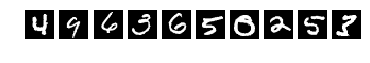

In [3]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
np.random.seed(1234) # set seed for deterministic ordering
p = np.random.permutation(mnist.data.shape[0])
X = mnist.data[p]
Y = mnist.target[p]

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X[i].reshape((28,28)), cmap='Greys_r')
    plt.axis('off')
plt.show()

X = X.astype(np.float32)/255
X_train = X[:60000]
X_test = X[60000:]
Y_train = Y[:60000]
Y_test = Y[60000:]



## Model

In [0]:
# Variables are place holders for input arrays. We give each variable a unique name.
data = mx.symbol.Variable('data')

# The input is fed to a fully connected layer that computes Y=WX+b.
# This is the main computation module in the network.
# Each layer also needs an unique name. We'll talk more about naming in the next section.
fc1  = mx.symbol.FullyConnected(data = data, name='fc1', num_hidden=128)
# Activation layers apply a non-linear function on the previous layer's output.
# Here we use Rectified Linear Unit (ReLU) that computes Y = max(X, 0).
act1 = mx.symbol.Activation(data = fc1, name='relu1', act_type="relu")

fc2  = mx.symbol.FullyConnected(data = act1, name = 'fc2', num_hidden = 64)
act2 = mx.symbol.Activation(data = fc2, name='relu2', act_type="relu")

fc3  = mx.symbol.FullyConnected(data = act2, name='fc3', num_hidden=10)
# Finally we have a loss layer that compares the network's output with label and generates gradient signals.
mlp  = mx.symbol.SoftmaxOutput(data = fc3, name = 'softmax')

In [0]:
batch_size = 100
train_iter = mx.io.NDArrayIter(X_train, Y_train, batch_size=batch_size)
test_iter = mx.io.NDArrayIter(X_test, Y_test, batch_size=batch_size)

In [6]:
# ==================Binding=====================
# The symbol we created is only a graph description.
# To run it, we first need to allocate memory and create an executor by 'binding' it.
# In order to bind a symbol, we need at least two pieces of information: context and input shapes.
# Context specifies which device the executor runs on, e.g. cpu, GPU0, GPU1, etc.
# Input shapes define the executor's input array dimensions.
# MXNet then run automatic shape inference to determine the dimensions of intermediate and output arrays.

# data iterators defines shapes of its output with provide_data and provide_label property.
input_shapes = dict(train_iter.provide_data+train_iter.provide_label)
print ('input_shapes', input_shapes)
# We use simple_bind to let MXNet allocate memory for us.
# You can also allocate memory youself and use bind to pass it to MXNet.
exe = mlp.simple_bind(ctx=mx.gpu(0), **input_shapes)

# ===============Initialization=================
# First we get handle to input arrays
arg_arrays = dict(zip(mlp.list_arguments(), exe.arg_arrays))
data = arg_arrays[train_iter.provide_data[0][0]]
label = arg_arrays[train_iter.provide_label[0][0]]

# We initialize the weights with uniform distribution on (-0.01, 0.01).
init = mx.init.Uniform(scale=0.01)
for name, arr in arg_arrays.items():
    if name not in input_shapes:
        init(name, arr)
    
# We also need to create an optimizer for updating weights
#opt = mx.optimizer.SGD(
    #learning_rate=0.1,rescale_grad=1.0/train_iter.batch_size,lr_scheduler=sched)
    #momentum=0.9,
    #wd=0.00001,
    #rescale_grad=1.0/train_iter.batch_size)
#updater = mx.optimizer.get_updater(opt)

# Finally we need a metric to print out training progress
metric = mx.metric.CrossEntropy() 

input_shapes {'data': (100, 784), 'softmax_label': (100,)}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Calling initializer with init(str, NDArray) has been deprecated.please use init(mx.init.InitDesc(...), NDArray) instead.


In [7]:
nb = len(X_train)/batch_size
nb

600.0

In [0]:
sched=lr_find(1e-4,nb,end_lr=1)

In [0]:
# We also need to create an optimizer for updating weights
opt = mx.optimizer.SGD(
    learning_rate=1,
    momentum=0.9,
    wd=0.00001,
    rescale_grad=1.0/train_iter.batch_size,lr_scheduler=sched)

updater = mx.optimizer.get_updater(opt)


In [10]:
counter=0
# Training loop begines
for epoch in range(1):
    train_iter.reset()
    metric.reset()
    sched.reset()
    t = 0
    sched.on_train_begin()

    for batch in train_iter:

        data[:] = batch.data[0]
        label[:] = batch.label[0]
        outputs=exe.forward(is_train=True)
        exe.backward()
        
        # Update
        tmp=0

        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)
            tmp+=1
        counter+=1   
        metric.update(batch.label, exe.outputs)
        e=metric.get()
        err_train=e[1]
        sched.on_batch_end(err_train)#loss)

        t += 1
        if t % 100 == 0:
            print('epoch:', epoch, 'iter:', t, 'metric:', metric.get())
  

epoch: 0 iter: 100 metric: ('cross-entropy', 2.3020539138793947)
epoch: 0 iter: 200 metric: ('cross-entropy', 2.301605969238281)
epoch: 0 iter: 300 metric: ('cross-entropy', 2.276343571980794)
epoch: 0 iter: 400 metric: ('cross-entropy', 2.0086743171691896)
epoch: 0 iter: 500 metric: ('cross-entropy', 1.7013168855285645)
epoch: 0 iter: 600 metric: ('cross-entropy', 1.4692819540023803)


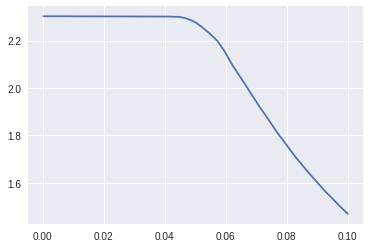

In [11]:
plt.plot(sched.lrs, sched.losses)


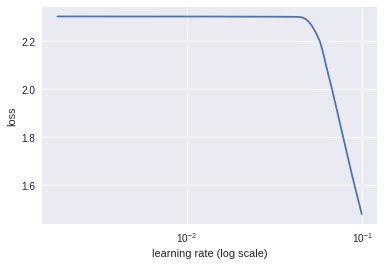

In [12]:
sched.plot()

From the graph, we can find that 0.01 is a good learning rate. 

### Learning with the suggested learning rate

In [0]:
# We also need to create an optimizer for updating weights
opt = mx.optimizer.SGD(
    learning_rate=.08,rescale_grad=1.0/train_iter.batch_size)


In [0]:
updater.optimizer.lr_scheduler=None


In [0]:
updater = mx.optimizer.get_updater(opt)

In [0]:
metric = mx.metric.Accuracy()

In [18]:


# Training loop begines
for epoch in range(10):
    train_iter.reset()
    metric.reset()
    t = 0
    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]
        
        # Forward
        outputs=exe.forward(is_train=True)
        
        # You perform operations on exe.outputs here if you need to.
        # For example, you can stack a CRF on top of a neural network.
        
        # Backward
        exe.backward()
        
        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)
        metric.update(batch.label, exe.outputs)
        t += 1
        if t % 100 == 0:
            print('epoch:', epoch, 'iter:', t, 'metric:', metric.get())

epoch: 0 iter: 100 metric: ('accuracy', 0.9859)
epoch: 0 iter: 200 metric: ('accuracy', 0.9848)
epoch: 0 iter: 300 metric: ('accuracy', 0.9853666666666666)
epoch: 0 iter: 400 metric: ('accuracy', 0.98535)
epoch: 0 iter: 500 metric: ('accuracy', 0.98566)
epoch: 0 iter: 600 metric: ('accuracy', 0.9861166666666666)
epoch: 1 iter: 100 metric: ('accuracy', 0.9868)
epoch: 1 iter: 200 metric: ('accuracy', 0.986)
epoch: 1 iter: 300 metric: ('accuracy', 0.9867666666666667)
epoch: 1 iter: 400 metric: ('accuracy', 0.9869)
epoch: 1 iter: 500 metric: ('accuracy', 0.98712)
epoch: 1 iter: 600 metric: ('accuracy', 0.9875166666666667)
epoch: 2 iter: 100 metric: ('accuracy', 0.988)
epoch: 2 iter: 200 metric: ('accuracy', 0.98705)
epoch: 2 iter: 300 metric: ('accuracy', 0.9879666666666667)
epoch: 2 iter: 400 metric: ('accuracy', 0.988125)
epoch: 2 iter: 500 metric: ('accuracy', 0.98836)
epoch: 2 iter: 600 metric: ('accuracy', 0.9888333333333333)
epoch: 3 iter: 100 metric: ('accuracy', 0.9893)
epoch: 3 it

## Learning with the a guessed learning rate

In [0]:
# We also need to create an optimizer for updating weights
opt = mx.optimizer.SGD(
    learning_rate=0.1,
    momentum=0.9,
    wd=0.00001,
    rescale_grad=1.0/train_iter.batch_size)
updater.optimizer.lr_scheduler=None


In [0]:
updater = mx.optimizer.get_updater(opt)

In [0]:
metric = mx.metric.Accuracy()

In [22]:
# Training loop begines
for epoch in range(10):
    train_iter.reset()
    metric.reset()
    t = 0
    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]
        
        # Forward
        outputs=exe.forward(is_train=True)
        
        # You perform operations on exe.outputs here if you need to.
        # For example, you can stack a CRF on top of a neural network.
        
        # Backward
        exe.backward()
        
        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)
        metric.update(batch.label, exe.outputs)
        t += 1
        if t % 100 == 0:
            print('epoch:', epoch, 'iter:', t, 'metric:', metric.get())

epoch: 0 iter: 100 metric: ('accuracy', 0.9364)
epoch: 0 iter: 200 metric: ('accuracy', 0.94045)
epoch: 0 iter: 300 metric: ('accuracy', 0.9454666666666667)
epoch: 0 iter: 400 metric: ('accuracy', 0.948875)
epoch: 0 iter: 500 metric: ('accuracy', 0.95196)
epoch: 0 iter: 600 metric: ('accuracy', 0.95445)
epoch: 1 iter: 100 metric: ('accuracy', 0.9676)
epoch: 1 iter: 200 metric: ('accuracy', 0.96805)
epoch: 1 iter: 300 metric: ('accuracy', 0.9698)
epoch: 1 iter: 400 metric: ('accuracy', 0.970675)
epoch: 1 iter: 500 metric: ('accuracy', 0.97082)
epoch: 1 iter: 600 metric: ('accuracy', 0.9715666666666667)
epoch: 2 iter: 100 metric: ('accuracy', 0.9752)
epoch: 2 iter: 200 metric: ('accuracy', 0.9754)
epoch: 2 iter: 300 metric: ('accuracy', 0.9771)
epoch: 2 iter: 400 metric: ('accuracy', 0.977825)
epoch: 2 iter: 500 metric: ('accuracy', 0.97762)
epoch: 2 iter: 600 metric: ('accuracy', 0.9776833333333333)
epoch: 3 iter: 100 metric: ('accuracy', 0.9808)
epoch: 3 iter: 200 metric: ('accuracy', 

## Conclusion
with the learn rate finder, we got an accuracy of .9953 whereas with the guessed learning rate we got .98886 accuracy.